In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Library

In [ ]:
!pip install tensorflow_text

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

read data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42
url_dataset = '/content/drive/MyDrive/review_polarity'
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    url_dataset,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    url_dataset,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    url_dataset,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2000 files belonging to 1 classes.
Using 1600 files for training.
Found 2000 files belonging to 1 classes.
Using 400 files for validation.
Found 2000 files belonging to 1 classes.


Preprocessing

In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'tibet has entered the american consciousness slowly during the past few years and burst into the forefront recently . \nthe dalai lama has made speaking tours , tibetan designs and artifacts are showing up in shops , the plight of the people has captured the imagination of major actors and artists and now there are two big budget films within as many months . \n " kundun " ( " presence " , a name the monks call the young dalai lama ) opens in 1937 with the search for the 14th incarnation of the tibetan leader . \na group of monks enters a village and a two-year-old child catches their attention . \nthe young boy proves himself by identifying possessions of the previous holy man as " mine " . \nhe and his family are then moved to a monastery in lhassa where he is to be prepared to take his position as the religious and political leader of the country . \nhe is forced into difficult decisions when china invades the country in 1950 . \nthe peaceful and isolated country is ill-eq

BERT

In [ ]:
tfhub_handle_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
tfhub_handle_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f0d723edf50>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.92169875 -0.3935344  -0.5393166   0.6825622   0.43848413 -0.14021155
  0.8774711   0.2604335  -0.63112926 -0.9999658  -0.2631998   0.8510528 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451553  0.25141686  0.19075039 ... -0.24845105  0.38568538
   0.13291036]
 [-0.5947863  -0.3942036   0.2524563  ... -0.7694673   1.1564169
   0.32475716]
 [ 0.00641508 -0.15766457  0.5461022  ... -0.17451054  0.6028961
   0.42672238]
 ...
 [ 0.21948323 -0.20927078  0.53868306 ...  0.24693573  0.18250985
  -0.4442707 ]
 [ 0.01080235 -0.44553167  0.35990986 ...  0.31722772  0.23562811
  -0.63070565]
 [ 0.29321152 -0.10581909  0.6114754  ...  0.20745839  0.1449465
  -0.35353357]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


tf.Tensor([[0.25279504]], shape=(1, 1), dtype=float32)


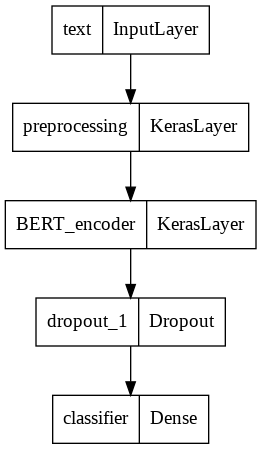

In [ ]:
tf.keras.utils.plot_model(classifier_model)


Train Model

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with <tensorflow_hub.keras_layer.KerasLayer object at 0x7f0d723edf50>
Epoch 1/15
50/50 [==============================] - 887s 18s/step - loss: 0.7398 - binary_accuracy: 0.8494 - val_loss: 0.6683 - val_binary_accuracy: 0.9550
Epoch 2/15
50/50 [==============================] - 867s 17s/step - loss: 0.5891 - binary_accuracy: 0.9525 - val_loss: 0.4799 - val_binary_accuracy: 0.9975
Epoch 3/15
50/50 [==============================] - 864s 17s/step - loss: 0.4152 - binary_accuracy: 0.9925 - val_loss: 0.3433 - val_binary_accuracy: 0.9950
Epoch 4/15
50/50 [==============================] - 864s 17s/step - loss: 0.2976 - binary_accuracy: 0.9975 - val_loss: 0.2520 - val_binary_accuracy: 0.9900
Epoch 5/15
50/50 [==============================] - 866s 17s/step - loss: 0.2207 - binary_accuracy: 0.9962 - val_loss: 0.1915 - val_binary_accuracy: 0.9875
Epoch 6/15
50/50 [==============================] - 861s 17s/step - loss: 0.1722 - binary_accuracy: 0.9931 - val_loss: 0.1509 - val_bin

Evaluate

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

63/63 [==============================] - 874s 14s/step - loss: 0.0627 - binary_accuracy: 0.9965
Loss: 0.06266913563013077
Accuracy: 0.9965000152587891
